<a href="https://colab.research.google.com/github/marcos-lopez-lab/bkds/blob/main/DSHackaton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install tensorflow==2.1.0

     |████████████████████████████████| 421.8 MB 16 kB/s 
     |████████████████████████████████| 448 kB 25.2 MB/s 
     |████████████████████████████████| 50 kB 2.9 MB/s 
     |████████████████████████████████| 3.8 MB 17.8 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=07022e77844ec54d6f701995eec261bcb2fcf9a41c9621792035a52cdd100df7
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Succes

In [3]:
import tensorflow as tf
print(tf.__version__)

2.1.0


In [4]:
!pip install keras==2.3.1

     |████████████████████████████████| 377 kB 5.3 MB/s 
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0


In [5]:
import keras
print(keras.__version__)

Using TensorFlow backend.


2.3.1


In [6]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

################################################################
def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    
    return model

In [7]:
from keras.utils import normalize
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import glob

In [8]:
from zipfile import ZipFile
file_name = 'TRAIN_FULL.zip'

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [9]:
from zipfile import ZipFile
file_name = 'Test_Order.zip'

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [10]:
def rle_encoding(x):
    '''
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten()!=0) [0]# .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

In [8]:
SIZE = 256
image_dataset = [] 
mask_dataset = []


for image_name in glob.glob('Mini_train_2/Image/*.png'):
  image = cv2.imread(image_name, 0)
  image = Image.fromarray(image)
  image = image.resize((SIZE, SIZE))
  image_dataset.append(np.array(image))

for image_name in glob.glob('Mini_train_2/Mask/*.png'):
  image = cv2.imread(image_name,0)
  image = Image.fromarray(image)
  image = image.resize((SIZE, SIZE))
  mask_dataset.append(np.array(image))

In [9]:
#Normalize images
image_dataset = np.expand_dims(normalize(np.array(image_dataset), axis=1),3)
#D not normalize masks, just rescale to 0 to 1.
mask_dataset = np.expand_dims((np.array(mask_dataset)),3) /255.

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.10, random_state = 0)

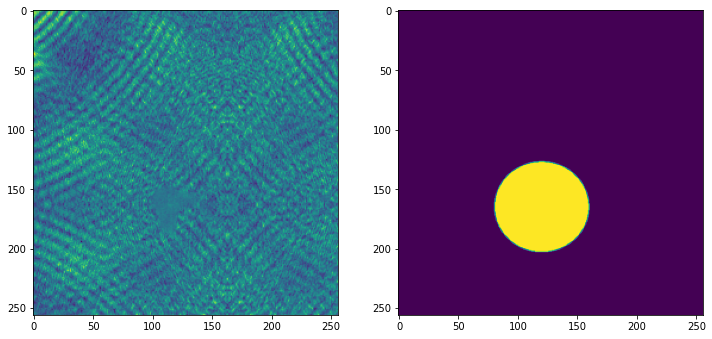

In [11]:
import random
import numpy as np
image_number = random.randint(0, len(X_train))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(X_train[image_number], (256, 256)))
plt.subplot(122)
plt.imshow(np.reshape(y_train[image_number], (256, 256)))
plt.show()

In [12]:
IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH  = image_dataset.shape[2]
IMG_CHANNELS = image_dataset.shape[3]

def get_model():
    return simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

model = get_model()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 256, 256, 16) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 16) 2320        dropout_1[0][0]                  
____________________________________________________________________________________________

In [22]:
history = model.fit(X_train, y_train, 
                    batch_size = 16, 
                    verbose=6, 
                    epochs=50, 
                    validation_data=(X_test, y_test), 
                    shuffle=False)

Train on 36 samples, validate on 4 samples
Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Epoch 31/50
Epoch 32/50
Epoch 33/50
Epoch 34/50
Epoch 35/50
Epoch 36/50
Epoch 37/50
Epoch 38/50
Epoch 39/50
Epoch 40/50
Epoch 41/50
Epoch 42/50
Epoch 43/50
Epoch 44/50
Epoch 45/50
Epoch 46/50
Epoch 47/50
Epoch 48/50
Epoch 49/50
Epoch 50/50


In [23]:
_, acc = model.evaluate(X_test, y_test)
print("Accuracy = ", (acc * 100.0), "%")

4/4 [==============================] - 1s 200ms/step
Accuracy =  98.20823669433594 %


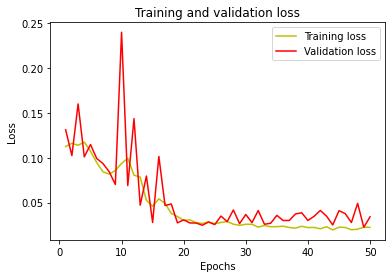

In [24]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

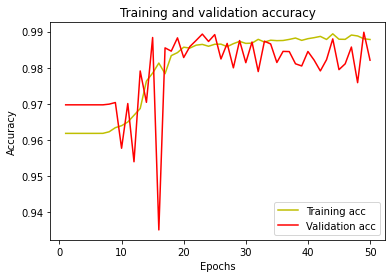

In [25]:
#acc = history.history['acc']
acc = history.history['accuracy']
#val_acc = history.history['val_acc']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [26]:
#IOU
y_pred = model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and(y_test, y_pred_thresholded)
union = np.logical_or(y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

IoU socre is:  0.6335705919452203


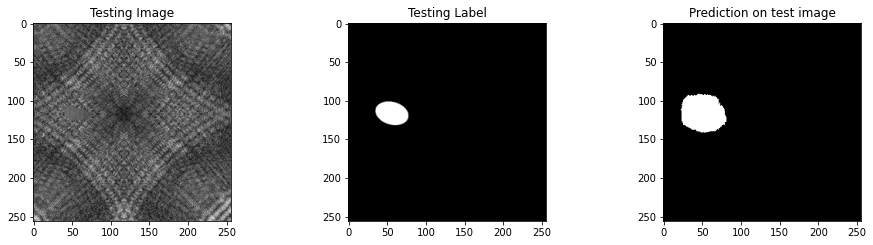

In [28]:
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.2).astype(np.uint8)


#test_img_other = cv2.imread('data/test_images/img8.tif', 0)
#test_img_other_norm = np.expand_dims(normalize(np.array(test_img_other), axis=1),2)
#test_img_other_norm=test_img_other_norm[:,:,0][:,:,None]
#test_img_other_input=np.expand_dims(test_img_other_norm, 0)

#Predict and threshold for values above 0.5 probability
#Change the probability threshold to low value (e.g. 0.05) for watershed demo.
#prediction_other = (model.predict(test_img_other_input)[0,:,:,0] > 0.2).astype(np.uint8)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')
plt.show()


In [30]:
def transformer(image_file,model):
  test_img_other = cv2.imread(image_file, 0)
  test_img_other = Image.fromarray(test_img_other)
  test_img_other = test_img_other.resize((256, 256))
  test_img_other_norm = np.expand_dims(normalize(np.array(test_img_other), axis=1),2)
  test_img_other_norm=test_img_other_norm[:,:,0][:,:,None]
  test_img_other_input=np.expand_dims(test_img_other_norm, 0)

  predic_other = (model.predict(test_img_other_input)[0,:,:,0] > 0.2).astype(np.uint8)
  image_back = Image.fromarray(predic_other)
  image_back = image_back.resize((512, 512))

  img_end= np.array(image_back)
  encoded = rle_encoding(img_end)
  return encoded
  #return predic_other

In [151]:
new_list = []

for i_x in glob.glob('Test_Order/1/*.png'):
  tfue = transformer(i_x)
  new_list.append([int(i_x[-8:-4]),' '.join(str(y) for y in tfue)])


df = pd.DataFrame(new_list, columns = ['ImageId', 'EncodedPixels'])
df = df.sort_values(by=['ImageId'])
df.head()

,ImageId,EncodedPixels
15,9000,51 60 563 60 1073 2 1077 50 1585 2 1589 50 209...
31,9001,1 2 301 82 513 2 813 82 1329 72 1841 72 2351 7...
43,9002,4371 30 4883 30 5381 2 5385 2 5389 2 5393 36 5...
2,9003,49 86 561 86 1077 2 1081 74 1589 2 1593 74 209...
10,9004,275 36 787 36 1305 28 1817 28 2323 36 2835 36 ...


In [152]:
df.to_csv('prueba.csv', index = False)

In [147]:
df = pd.read_csv('submission_example.csv')
df.head()

,ImageId,EncodedPixels
0,9000,13866 14 14371 29 14878 38 15386 46 15895 52 1...
1,9001,53094 12 53604 17 54114 21 54624 25 55135 27 5...
2,9002,36002 14 36507 28 37015 36 37524 43 38033 49 3...
3,9003,81471 8 81978 18 82486 26 82996 30 83506 34 84...
4,9004,115 38 626 40 1137 43 1648 45 2159 48 2670 50 ...


In [53]:
def graph_test(model,umbral):
  test_img_number = np.random.randint(0, len(X_test))
  test_img = X_test[test_img_number]
  ground_truth=y_test[test_img_number]
  test_img_norm=test_img[:,:,0][:,:,None]
  test_img_input=np.expand_dims(test_img_norm, 0)
  #umbral 0.2 
  prediction = (model.predict(test_img_input)[0,:,:,0] > umbral).astype(np.uint8)

  plt.figure(figsize=(16, 8))
  plt.subplot(231)
  plt.title('Testing Image')
  plt.imshow(test_img[:,:,0], cmap='gray')
  plt.subplot(232)
  plt.title('Testing Label')
  plt.imshow(ground_truth[:,:,0], cmap='gray')
  plt.subplot(233)
  plt.title('Prediction on test image')
  plt.imshow(prediction, cmap='gray')
  plt.show()

Modelo 2 

In [25]:
SIZE = 256
image_dataset = [] 
mask_dataset = []

### Direction
number_folder = 2

for image_name in glob.glob(f'TRAIN_FULL/Image_Order/2/*.png'):
  image = cv2.imread(image_name, 0)
  image = Image.fromarray(image)
  image = image.resize((SIZE, SIZE))
  image_dataset.append(np.array(image))

for image_name in glob.glob('TRAIN_FULL/Mask_Order/2/*.png'):
  image = cv2.imread(image_name,0)
  image = Image.fromarray(image)
  image = image.resize((SIZE, SIZE))
  mask_dataset.append(np.array(image))

#Normalize images
image_dataset = np.expand_dims(normalize(np.array(image_dataset), axis=1),3)
#D not normalize masks, just rescale to 0 to 1.
mask_dataset = np.expand_dims((np.array(mask_dataset)),3) /255.

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.15, random_state = 0)

IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH  = image_dataset.shape[2]
IMG_CHANNELS = image_dataset.shape[3]

def get_model():
    return simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)


### CHANGE MODEL
model_2 = get_model()
### CHANGE OBJECT!!!
history_2 = model_2.fit(X_train, y_train, 
                    batch_size = 16, 
                    verbose=5, 
                    epochs=50, 
                    validation_data=(X_test, y_test), 
                    shuffle=False)


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 256, 256, 16) 160         input_2[0][0]                    
__________________________________________________________________________________________________
dropout_10 (Dropout)            (None, 256, 256, 16) 0           conv2d_20[0][0]                  
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 256, 256, 16) 2320        dropout_10[0][0]                 
____________________________________________________________________________________________

In [26]:
_, acc = model_2.evaluate(X_test, y_test)
print("Accuracy = ", (acc * 100.0), "%")

5/5 [==============================] - 2s 355ms/step
Accuracy =  98.81317019462585 %


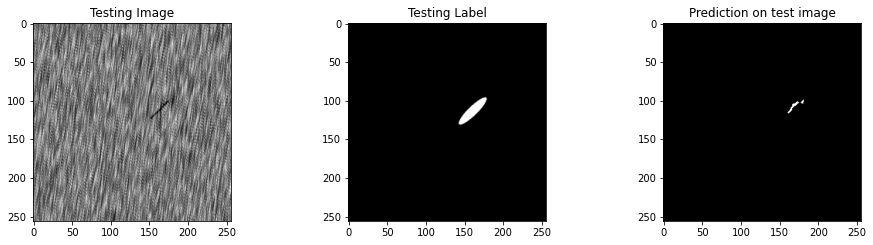

In [29]:
graph_test(model_2)

In [32]:
new_list = []

for i_x in glob.glob('Test_Order/2/*.png'):
  ###-----> def transformer(image_file,model):
  tfue = transformer(i_x, model_2)
  new_list.append([int(i_x[-8:-4]),' '.join(str(y) for y in tfue)])


df_2 = pd.DataFrame(new_list, columns = ['ImageId', 'EncodedPixels'])
df_2 = df_2.sort_values(by=['ImageId'])
df_2.head()

,ImageId,EncodedPixels
20,9050,42079 10 42591 10 43105 8 43617 8 44131 2 4464...
25,9051,101791 2 102303 2 102813 6 103325 6 103835 8 1...
5,9052,31959 6 32471 6 32981 10 33493 10 34007 2 3401...
17,9053,155895 4 156407 4 156917 6 157429 6 157941 6 1...
40,9054,


In [34]:
df_2.to_csv('parte_2.csv',index=None)

Modelo 3

In [52]:
SIZE = 256
image_dataset = [] 
mask_dataset = []

### Direction
number_folder = 3

for image_name in glob.glob(f'TRAIN_FULL/Image_Order/3/*.png'):
  image = cv2.imread(image_name, 0)
  image = Image.fromarray(image)
  image = image.resize((SIZE, SIZE))
  image_dataset.append(np.array(image))

for image_name in glob.glob('TRAIN_FULL/Mask_Order/3/*.png'):
  image = cv2.imread(image_name,0)
  image = Image.fromarray(image)
  image = image.resize((SIZE, SIZE))
  mask_dataset.append(np.array(image))

#Normalize images
image_dataset = np.expand_dims(normalize(np.array(image_dataset), axis=1),3)
#D not normalize masks, just rescale to 0 to 1.
mask_dataset = np.expand_dims((np.array(mask_dataset)),3) /255.

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.15, random_state = 0)

IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH  = image_dataset.shape[2]
IMG_CHANNELS = image_dataset.shape[3]

def get_model():
    return simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)


### CHANGE MODEL
model_3 = get_model()
### CHANGE OBJECT!!!
history_3 = model_3.fit(X_train, y_train, 
                    batch_size = 16, 
                    verbose=2, 
                    epochs=15, 
                    validation_data=(X_test, y_test), 
                    shuffle=False)

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_96 (Conv2D)              (None, 256, 256, 16) 160         input_6[0][0]                    
__________________________________________________________________________________________________
dropout_46 (Dropout)            (None, 256, 256, 16) 0           conv2d_96[0][0]                  
__________________________________________________________________________________________________
conv2d_97 (Conv2D)              (None, 256, 256, 16) 2320        dropout_46[0][0]                 
____________________________________________________________________________________________

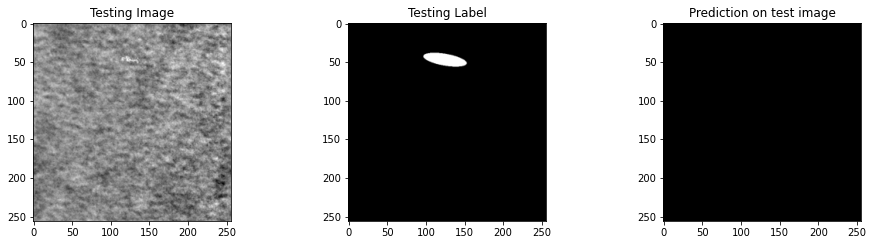

In [60]:
graph_test(model_3,umbral=0.8)

In [61]:
new_list = []

for i_x in glob.glob('Test_Order/3/*.png'):
  ###-----> def transformer(image_file,model):
  tfue = transformer(i_x, model_3)
  new_list.append([int(i_x[-8:-4]),' '.join(str(y) for y in tfue)])


df_3 = pd.DataFrame(new_list, columns = ['ImageId', 'EncodedPixels'])
df_3 = df_3.sort_values(by=['ImageId'])
df_3.head()

,ImageId,EncodedPixels
38,9100,1 18 21 6 29 6 37 6 45 6 53 6 61 6 69 6 77 6 8...
45,9101,1 18 21 6 29 6 37 6 45 6 53 6 61 6 69 6 77 6 8...
1,9102,1 18 21 6 29 6 37 6 45 6 53 6 61 6 69 6 77 6 8...
49,9103,1 18 21 6 29 6 37 6 45 6 53 6 61 6 69 6 77 6 8...
46,9104,1 18 21 6 29 6 37 6 45 6 53 6 61 6 69 6 77 6 8...


In [64]:
df_3.to_csv('parte_3.csv',index=None)

Modelo 4

In [69]:
SIZE = 256
image_dataset = [] 
mask_dataset = []

### Direction
number_folder = 4

for image_name in glob.glob(f'TRAIN_FULL/Image_Order/4/*.png'):
  image = cv2.imread(image_name, 0)
  image = Image.fromarray(image)
  image = image.resize((SIZE, SIZE))
  image_dataset.append(np.array(image))

for image_name in glob.glob('TRAIN_FULL/Mask_Order/4/*.png'):
  image = cv2.imread(image_name,0)
  image = Image.fromarray(image)
  image = image.resize((SIZE, SIZE))
  mask_dataset.append(np.array(image))

#Normalize images
image_dataset = np.expand_dims(normalize(np.array(image_dataset), axis=1),3)
#D not normalize masks, just rescale to 0 to 1.
mask_dataset = np.expand_dims((np.array(mask_dataset)),3) /255.

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.15, random_state = 0)

IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH  = image_dataset.shape[2]
IMG_CHANNELS = image_dataset.shape[3]

def get_model():
    return simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)


### CHANGE MODEL
model_4 = get_model()
### CHANGE OBJECT!!!
history_4 = model_4.fit(X_train, y_train, 
                    batch_size = 16, 
                    verbose=2, 
                    epochs=20, 
                    validation_data=(X_test, y_test), 
                    shuffle=False)

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_134 (Conv2D)             (None, 256, 256, 16) 160         input_8[0][0]                    
__________________________________________________________________________________________________
dropout_64 (Dropout)            (None, 256, 256, 16) 0           conv2d_134[0][0]                 
__________________________________________________________________________________________________
conv2d_135 (Conv2D)             (None, 256, 256, 16) 2320        dropout_64[0][0]                 
____________________________________________________________________________________________

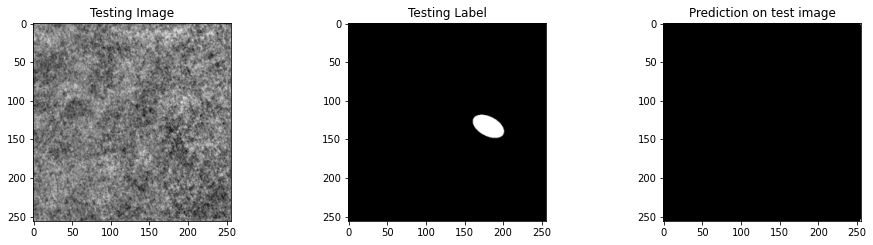

In [78]:
graph_test(model_4,umbral=0.3)

In [79]:
new_list = []

for i_x in glob.glob('Test_Order/4/*.png'):
  ###-----> def transformer(image_file,model):
  tfue = transformer(i_x, model_4)
  new_list.append([int(i_x[-8:-4]),' '.join(str(y) for y in tfue)])


df_3 = pd.DataFrame(new_list, columns = ['ImageId', 'EncodedPixels'])
df_3 = df_3.sort_values(by=['ImageId'])
df_3.head()

,ImageId,EncodedPixels
48,9150,1 2 5 2 133 2 509 6 517 2 645 2 1021 6 1537 2 ...
7,9151,1 2 5 2 129 2 205 2 221 2 437 2 511 4 517 2 64...
21,9152,1 2 5 2 509 6 517 2 1021 6 1537 2 2049 2 2559 ...
37,9153,1 2 5 2 109 22 293 2 381 2 429 2 509 6 517 2 6...
3,9154,1 2 5 2 117 2 121 2 125 2 129 10 141 2 373 2 4...


In [80]:
df_3.to_csv('parte_4.csv',index=None)

Modelo 5

In [81]:
SIZE = 256
image_dataset = [] 
mask_dataset = []

### Direction
number_folder = 5

for image_name in glob.glob(f'TRAIN_FULL/Image_Order/5/*.png'):
  image = cv2.imread(image_name, 0)
  image = Image.fromarray(image)
  image = image.resize((SIZE, SIZE))
  image_dataset.append(np.array(image))

for image_name in glob.glob('TRAIN_FULL/Mask_Order/5/*.png'):
  image = cv2.imread(image_name,0)
  image = Image.fromarray(image)
  image = image.resize((SIZE, SIZE))
  mask_dataset.append(np.array(image))

#Normalize images
image_dataset = np.expand_dims(normalize(np.array(image_dataset), axis=1),3)
#D not normalize masks, just rescale to 0 to 1.
mask_dataset = np.expand_dims((np.array(mask_dataset)),3) /255.

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.15, random_state = 0)

IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH  = image_dataset.shape[2]
IMG_CHANNELS = image_dataset.shape[3]

def get_model():
    return simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)


### CHANGE MODEL
model_5 = get_model()
### CHANGE OBJECT!!!
history_5 = model_5.fit(X_train, y_train, 
                    batch_size = 16, 
                    verbose=5, 
                    epochs=50, 
                    validation_data=(X_test, y_test), 
                    shuffle=False)

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_153 (Conv2D)             (None, 256, 256, 16) 160         input_9[0][0]                    
__________________________________________________________________________________________________
dropout_73 (Dropout)            (None, 256, 256, 16) 0           conv2d_153[0][0]                 
__________________________________________________________________________________________________
conv2d_154 (Conv2D)             (None, 256, 256, 16) 2320        dropout_73[0][0]                 
____________________________________________________________________________________________

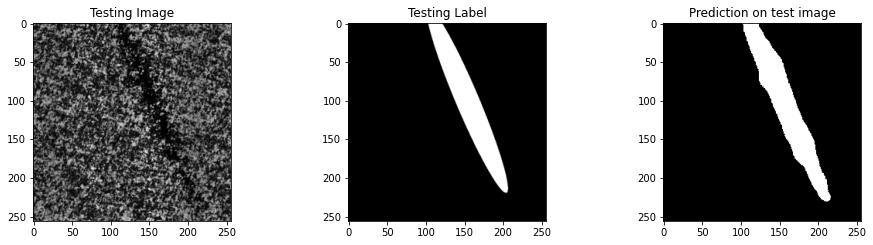

In [83]:
graph_test(model_5,umbral=0.2)

In [84]:
new_list = []

for i_x in glob.glob('Test_Order/5/*.png'):
  ###-----> def transformer(image_file,model):
  tfue = transformer(i_x, model_5)
  new_list.append([int(i_x[-8:-4]),' '.join(str(y) for y in tfue)])


df_5 = pd.DataFrame(new_list, columns = ['ImageId', 'EncodedPixels'])
df_5 = df_5.sort_values(by=['ImageId'])
df_5.head()

,ImageId,EncodedPixels
29,9200,48185 8 48697 8 49205 18 49717 18 50229 20 507...
34,9201,511 2 1023 2 169985 2 170497 2 171009 2 171521...
7,9202,77825 2 78337 2 78849 2 79361 2 79873 4 80385 ...
39,9203,45177 6 45689 6 46199 12 46711 12 47219 22 477...
24,9204,187 44 699 44 1221 28 1733 28 2259 2 2263 2 22...


In [85]:
df_5.to_csv('parte_5.csv')

Modelo 6

In [86]:
SIZE = 256
image_dataset = [] 
mask_dataset = []

### Direction
number_folder = 6

for image_name in glob.glob(f'TRAIN_FULL/Image_Order/6/*.png'):
  image = cv2.imread(image_name, 0)
  image = Image.fromarray(image)
  image = image.resize((SIZE, SIZE))
  image_dataset.append(np.array(image))

for image_name in glob.glob('TRAIN_FULL/Mask_Order/6/*.png'):
  image = cv2.imread(image_name,0)
  image = Image.fromarray(image)
  image = image.resize((SIZE, SIZE))
  mask_dataset.append(np.array(image))

#Normalize images
image_dataset = np.expand_dims(normalize(np.array(image_dataset), axis=1),3)
#D not normalize masks, just rescale to 0 to 1.
mask_dataset = np.expand_dims((np.array(mask_dataset)),3) /255.

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.15, random_state = 0)

IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH  = image_dataset.shape[2]
IMG_CHANNELS = image_dataset.shape[3]

def get_model():
    return simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)


### CHANGE MODEL
model_6 = get_model()
### CHANGE OBJECT!!!
history_6 = model_6.fit(X_train, y_train, 
                    batch_size = 16, 
                    verbose=5, 
                    epochs=50, 
                    validation_data=(X_test, y_test), 
                    shuffle=False)

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_172 (Conv2D)             (None, 256, 256, 16) 160         input_10[0][0]                   
__________________________________________________________________________________________________
dropout_82 (Dropout)            (None, 256, 256, 16) 0           conv2d_172[0][0]                 
__________________________________________________________________________________________________
conv2d_173 (Conv2D)             (None, 256, 256, 16) 2320        dropout_82[0][0]                 
___________________________________________________________________________________________

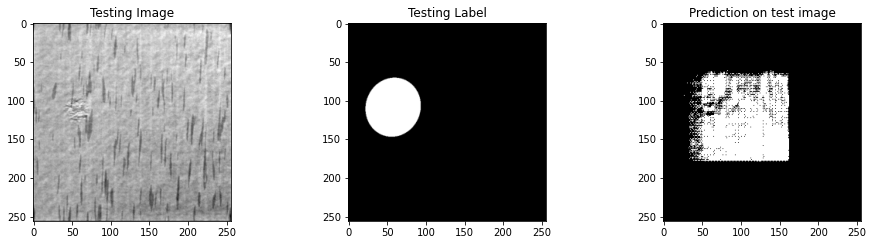

In [87]:
graph_test(model_6,umbral=0.2)

In [88]:
new_list = []

for i_x in glob.glob('Test_Order/6/*.png'):
  ###-----> def transformer(image_file,model):
  tfue = transformer(i_x, model_6)
  new_list.append([int(i_x[-8:-4]),' '.join(str(y) for y in tfue)])


df_6 = pd.DataFrame(new_list, columns = ['ImageId', 'EncodedPixels'])
df_6 = df_6.sort_values(by=['ImageId'])
df_6.head()

,ImageId,EncodedPixels
49,9250,32919 2 32925 2 33431 2 33437 2 33939 2 33943 ...
38,9251,29939 2 30451 2 30939 4 30955 10 30967 12 3098...
5,9252,1 2 513 2 35119 2 35631 2 36011 2 36139 2 3614...
33,9253,33939 2 34451 2 34959 2 35471 2 35987 2 36499 ...
43,9254,32059 2 32067 2 32083 2 32091 2 32571 2 32579 ...


In [89]:
df_6.to_csv('parte_6.csv',index=None)

Modelo 7

In [90]:
SIZE = 256
image_dataset = [] 
mask_dataset = []

### Direction
number_folder = 7

for image_name in glob.glob(f'TRAIN_FULL/Image_Order/7/*.png'):
  image = cv2.imread(image_name, 0)
  image = Image.fromarray(image)
  image = image.resize((SIZE, SIZE))
  image_dataset.append(np.array(image))

for image_name in glob.glob('TRAIN_FULL/Mask_Order/7/*.png'):
  image = cv2.imread(image_name,0)
  image = Image.fromarray(image)
  image = image.resize((SIZE, SIZE))
  mask_dataset.append(np.array(image))

#Normalize images
image_dataset = np.expand_dims(normalize(np.array(image_dataset), axis=1),3)
#D not normalize masks, just rescale to 0 to 1.
mask_dataset = np.expand_dims((np.array(mask_dataset)),3) /255.

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.15, random_state = 0)

IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH  = image_dataset.shape[2]
IMG_CHANNELS = image_dataset.shape[3]

def get_model():
    return simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)


### CHANGE MODEL
model_7 = get_model()
### CHANGE OBJECT!!!
history_7 = model_7.fit(X_train, y_train, 
                    batch_size = 16, 
                    verbose=5, 
                    epochs=50, 
                    validation_data=(X_test, y_test), 
                    shuffle=False)

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_191 (Conv2D)             (None, 256, 256, 16) 160         input_11[0][0]                   
__________________________________________________________________________________________________
dropout_91 (Dropout)            (None, 256, 256, 16) 0           conv2d_191[0][0]                 
__________________________________________________________________________________________________
conv2d_192 (Conv2D)             (None, 256, 256, 16) 2320        dropout_91[0][0]                 
___________________________________________________________________________________________

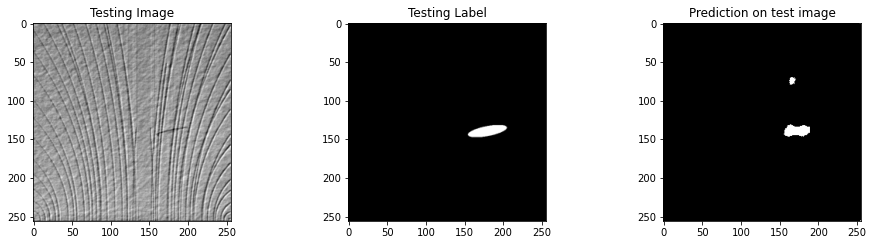

In [96]:
graph_test(model_7,umbral=0.2)

In [97]:
new_list = []

for i_x in glob.glob('Test_Order/7/*.png'):
  ###-----> def transformer(image_file,model):
  tfue = transformer(i_x, model_7)
  new_list.append([int(i_x[-8:-4]),' '.join(str(y) for y in tfue)])


df_7 = pd.DataFrame(new_list, columns = ['ImageId', 'EncodedPixels'])
df_7 = df_7.sort_values(by=['ImageId'])
df_7.head()

,ImageId,EncodedPixels
45,9350,1 2 511 4 1023 2 153911 2 153915 4 154423 2 15...
1,9351,1 2 511 4 1023 2 149733 16 150245 16 150757 18...
27,9352,1 2 511 4 1023 2 128293 2 128297 2 128805 2 12...
13,9353,1 2 511 4 1023 2 42373 2 42377 2 42885 2 42889...
30,9354,1 2 511 4 1023 2 56521 2 56525 2 57033 2 57037...


In [98]:
df_7.to_csv('parte_7.csv',index=None)

Modelo 8

In [99]:
SIZE = 256
image_dataset = [] 
mask_dataset = []

### Direction
number_folder = 8

for image_name in glob.glob(f'TRAIN_FULL/Image_Order/8/*.png'):
  image = cv2.imread(image_name, 0)
  image = Image.fromarray(image)
  image = image.resize((SIZE, SIZE))
  image_dataset.append(np.array(image))

for image_name in glob.glob('TRAIN_FULL/Mask_Order/8/*.png'):
  image = cv2.imread(image_name,0)
  image = Image.fromarray(image)
  image = image.resize((SIZE, SIZE))
  mask_dataset.append(np.array(image))

#Normalize images
image_dataset = np.expand_dims(normalize(np.array(image_dataset), axis=1),3)
#D not normalize masks, just rescale to 0 to 1.
mask_dataset = np.expand_dims((np.array(mask_dataset)),3) /255.

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.15, random_state = 0)

IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH  = image_dataset.shape[2]
IMG_CHANNELS = image_dataset.shape[3]

def get_model():
    return simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)


### CHANGE MODEL
model_8 = get_model()
### CHANGE OBJECT!!!
history_8 = model_8.fit(X_train, y_train, 
                    batch_size = 16, 
                    verbose=5, 
                    epochs=50, 
                    validation_data=(X_test, y_test), 
                    shuffle=False)

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_210 (Conv2D)             (None, 256, 256, 16) 160         input_12[0][0]                   
__________________________________________________________________________________________________
dropout_100 (Dropout)           (None, 256, 256, 16) 0           conv2d_210[0][0]                 
__________________________________________________________________________________________________
conv2d_211 (Conv2D)             (None, 256, 256, 16) 2320        dropout_100[0][0]                
___________________________________________________________________________________________

In [101]:
new_list = []

for i_x in glob.glob('Test_Order/8/*.png'):
  ###-----> def transformer(image_file,model):
  tfue = transformer(i_x, model_8)
  new_list.append([int(i_x[-8:-4]),' '.join(str(y) for y in tfue)])


df_8 = pd.DataFrame(new_list, columns = ['ImageId', 'EncodedPixels'])
df_8 = df_8.sort_values(by=['ImageId'])
df_8.head()

,ImageId,EncodedPixels
12,9300,235745 18 236257 18 236765 26 237277 26 237785...
26,9301,69119 2 69631 2 70113 2 70117 2 70121 2 70143 ...
9,9302,62975 2 63487 2 63999 2 64511 2 65023 2 65535 ...
18,9303,155845 2 155849 2 155853 2 155857 2 155861 2 1...
13,9304,180657 2 180661 2 180665 2 180669 2 180673 2 1...


In [102]:
df_8.to_csv('parte_8.csv')